In [1]:
# Allow to import without installing
import sys
sys.path.insert(0, "..")

# Piedmont, California

Let's replicate an OSMnx example by finding all the buildings in Piedmont.

Step one is to find the region which forms the town of Piedmont.  As usual, the best way to solve this problem is to play around on www.openstreetmap.org until you find the correct element.  In this case, it's a "way" which outlines the town.  A bit of browsing around the wiki finds that the important tag is "boundary":"administrative".  See http://wiki.openstreetmap.org/w/index.php?title=Tag:boundary%3Dadministrative

In [2]:
import os
filename = os.path.join("..", "..", "..", "Data", "california-latest.db")

In [3]:
import osmdigest.sqlite as sq

db = sq.OSM_SQLite(filename)

In [4]:
all_admin_boundaries = db.search_relation_tags({"boundary": "administrative", "name":"Piedmont"})
all_admin_boundaries

[Relation(2999176 ->  [Member(type='way', ref=33088737, role='outer'), Member(type='node', ref=150950648, role='label')] {'name': 'Piedmont', 'type': 'boundary', 'source': 'TIGER/Line® 2008 Place Shapefiles (http://www.census.gov/geo/www/tiger/)', 'website': 'http://www.ci.piedmont.ca.us/', 'boundary': 'administrative', 'wikidata': 'Q570301', 'tiger:CPI': 'N', 'wikipedia': 'en:Piedmont, California', 'board_type': 'city', 'place_name': 'Piedmont', 'population': '73812', 'tiger:NAME': 'Piedmont', 'admin_level': '8', 'tiger:PCICBSA': 'N', 'tiger:PLACEFP': '56938', 'tiger:PLACENS': '02411418', 'tiger:PLCIDFP': '0656938', 'tiger:NAMELSAD': 'Piedmont city'})]

In [5]:
all_admin_boundaries = [db.complete_relation(rel) for rel in all_admin_boundaries]

In [6]:
import osmdigest.geometry as geometry
import geopandas as gpd
%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
piedmont = geometry.dataframe_from_elements(all_admin_boundaries)
piedmont

,admin_level,board_type,boundary,geometry,name,osm_id,place_name,population,source,tiger:CPI,tiger:NAME,tiger:NAMELSAD,tiger:PCICBSA,tiger:PLACEFP,tiger:PLACENS,tiger:PLCIDFP,type,website,wikidata,wikipedia
0,8,city,administrative,"POLYGON ((-122.244191 37.819027, -122.244287 3...",Piedmont,2999176,Piedmont,73812,TIGER/Line® 2008 Place Shapefiles (http://www....,N,Piedmont,Piedmont city,N,56938,02411418,0656938,boundary,http://www.ci.piedmont.ca.us/,Q570301,"en:Piedmont, California"


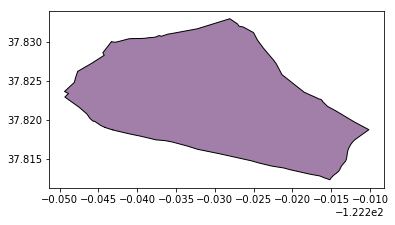

In [12]:
piedmont.plot()

In [13]:
piedmont.bounds

,minx,miny,maxx,maxy
0,-122.249374,37.812276,-122.210148,37.833026


## Find all buildings inside this region.

I have found no particularly efficient way to perform this sort of query.

The best option appears to be to generate a new database by extracting the parts we want based on a bounding box.  Then we can interactively explore this extract.

In [14]:
import os, sys
try:
    os.remove("piedmont.db")
except Exception as ex:
    print("{}/{}".format(type(ex), ex), file=sys.stderr)
    pass

bounds = piedmont.bounds.ix[0]
sq.extract(db, bounds.minx, bounds.maxx, bounds.miny, bounds.maxy, "piedmont.db")

In [15]:
pied_db = sq.OSM_SQLite("piedmont.db")
frame = geometry.dataframe_from_elements((db.complete_way(way)
    for way in pied_db.search_way_tag_keys({"building"})), polygonise=True)

In [16]:
frame[:5]

,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,address,alt_name,amenity,area,atm,...,owner,phone,religion,shop,smoking,source,tomb,tourism,website,wikipedia
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Piedmont,631,94611,NaN,Moraga Avenue,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


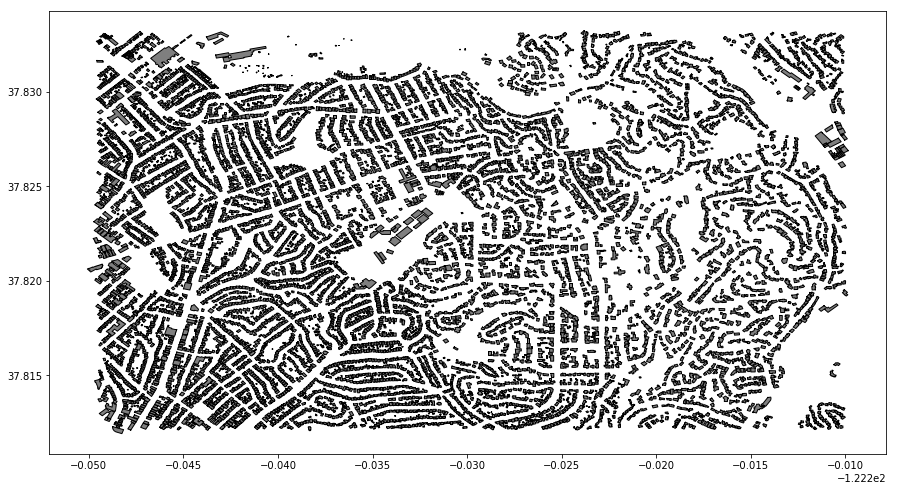

In [17]:
frame.plot(figsize=(15,10), color="black")

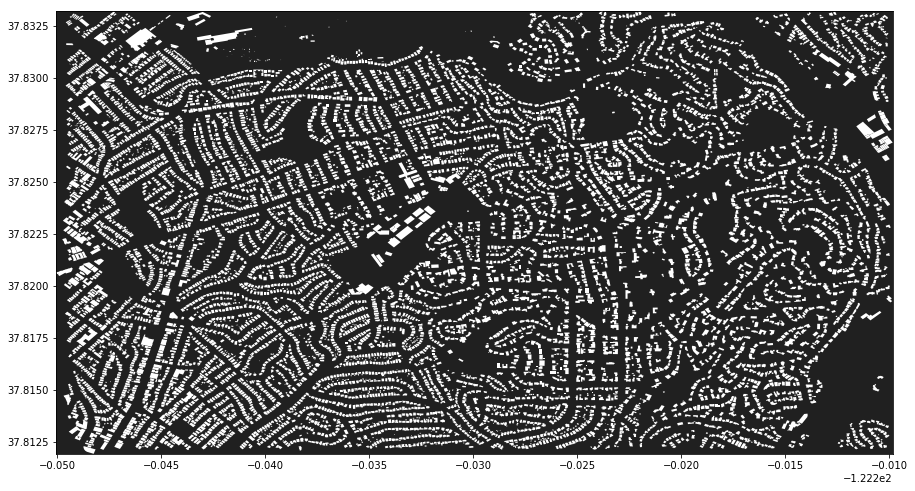

In [18]:
# Idea from OSMNX.  Much faster to use descartes and patches.

from descartes import PolygonPatch
from matplotlib.collections import PatchCollection

def manual_plot(frame):
    bgcolor = "#202020"
    fig, ax = plt.subplots(figsize=(15,10))#, facecolor=bgcolor)
    ax.set_facecolor(bgcolor)

    patches = []
    for geo in frame['geometry']:
        if geo.geometryType() == "Polygon":
            patches.append(PolygonPatch(geo))
        elif geo.geometryType() == "MultiPolygon":
            for subpolygon in geo:
                patches.append(PolygonPatch(subpolygon))
        else:
            raise Exception(geo.geometryType())
    pc = PatchCollection(patches, facecolor="white", edgecolor="white", linewidth=0, alpha=1)
    ax.add_collection(pc)


    left, bottom, right, top = frame.total_bounds
    ax.set_xlim((left, right))
    ax.set_ylim((bottom, top))

    ax.set_aspect('equal')
    
manual_plot(frame)

## Use `geopandas` to perform the intersection

In [19]:
frame = gpd.GeoDataFrame({"geometry":frame.geometry, "osm_id":frame.osm_id})
frame[:5]

,geometry,osm_id
0,"POLYGON ((-122.2122952 37.83233, -122.2121142 ...",475332609
1,"POLYGON ((-122.2171537 37.8316375, -122.217087...",475332616
2,"POLYGON ((-122.2330227 37.8311177, -122.232899...",285544832
3,"POLYGON ((-122.22222 37.8331485, -122.2221446 ...",475332625
4,"POLYGON ((-122.2142242 37.8316857, -122.214171...",475332627


In [20]:
piedmont

,admin_level,board_type,boundary,geometry,name,osm_id,place_name,population,source,tiger:CPI,tiger:NAME,tiger:NAMELSAD,tiger:PCICBSA,tiger:PLACEFP,tiger:PLACENS,tiger:PLCIDFP,type,website,wikidata,wikipedia
0,8,city,administrative,"POLYGON ((-122.244191 37.819027, -122.244287 3...",Piedmont,2999176,Piedmont,73812,TIGER/Line® 2008 Place Shapefiles (http://www....,N,Piedmont,Piedmont city,N,56938,02411418,0656938,boundary,http://www.ci.piedmont.ca.us/,Q570301,"en:Piedmont, California"


In [21]:
piedmont_reduced = gpd.GeoDataFrame({"geometry":piedmont.geometry})

In [22]:
piedmont_frame = gpd.overlay(piedmont_reduced, frame, how="intersection")
piedmont_frame.crs = {'init':'epsg:4326'}
piedmont_frame = piedmont_frame.to_crs({"init":"epsg:3310"})

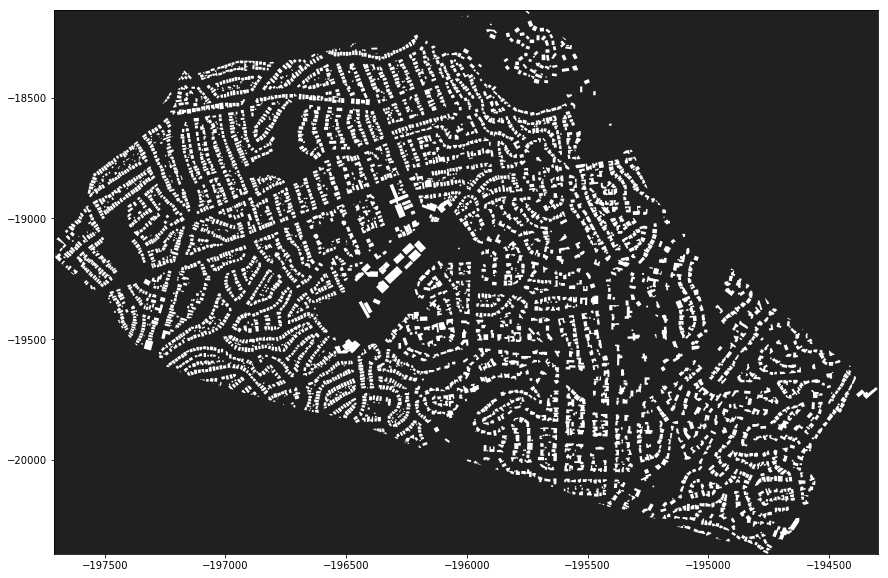

In [23]:
manual_plot(piedmont_frame)